本章では次の内容を取り上げる。

- モデルの性能の偏りのない推定量の算出
- 機会学習のアルゴリズムに共通する問題の診断
- 機会学習のモデルのチューニング
- さまざまな性能指標に基づく予測モデルの評価

## 6.1 パイプラインによるワークフローの効率化

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                'breast-cancer-wisconsin/wdbc.data',
                header=None)

30個の特徴量をNumpy配列のオブジェクトXに割り当てる。LabelEncoderを使用することで、元のクラスラベルの文字列表現('M'および'B')を整数に変換。

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

配列yに格納されたクラスラベルを符号化した後は、悪性クラス1、良性クラス0で表されるようになる。具体的に示すには、適合されたLabelEncoderのtransformメソッドを呼び出し、2つのダミークラスラベルを渡せばよい。

In [3]:
le.transform(['M','B'])

array([1, 0], dtype=int64)

データセットをトレニンーグデータセットとテストデータセットに分割(8:2)

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=1)

## 6.1 パイプラインで変換器と推定器を結合する
最適な性能を得るために入力特徴量の尺度をそろえる。そのため標準化して、ロジスティクス回帰といった線形分類器に入力できるようにする。さらに**主成分分析(PCA)**を使用し、データを最初の30次元から2次元の部分空間に圧縮する。
トレーニングデータセットとテストデータセットの学習と変換を別々に行う代わりにStandardScaler,PCA,LogisticRegressionの3つのオブジェクトをパイプラインで結合する。

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# 連結する処理としてスケーリング、主成分分析、ロジスティクス回帰を指定
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1))
pipe_lr.fit(X_train,y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test,y_test))

Test Accuracy: 0.956


## 6.2 k分割交差検証を使ったモデルの性能の評価

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 分割データ、分割数、乱数背姿勢器の状態を指定し、
# 層化k分割交差検証イテレータを表すStratifiedKFoldクラスのインスタンス化
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train,y_train)
scores = []

"""
イテレータのインデックスと要素をループ処理：（上から順に）
    データをモデルに適合
    テストデータの正解率を算出
    リストに正解率を追加
    分割の番号、0以上の要素数、正解率を出力
"""
for k ,(train,test)in enumerate(kfold):
    # print(X_train[train])
    pipe_lr.fit(X_train[train],y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.:%s ,Acc: %.3f' % 
         (k+1,np.bincount(y_train[train]),score))

Fold:  1, Class dist.:[256 153] ,Acc: 0.935
Fold:  2, Class dist.:[256 153] ,Acc: 0.935
Fold:  3, Class dist.:[256 153] ,Acc: 0.957
Fold:  4, Class dist.:[256 153] ,Acc: 0.957
Fold:  5, Class dist.:[256 153] ,Acc: 0.935
Fold:  6, Class dist.:[257 153] ,Acc: 0.956
Fold:  7, Class dist.:[257 153] ,Acc: 0.978
Fold:  8, Class dist.:[257 153] ,Acc: 0.933
Fold:  9, Class dist.:[257 153] ,Acc: 0.956
Fold: 10, Class dist.:[257 153] ,Acc: 0.956


In [7]:
# 正解率の平均と標準偏差を出力
print('\nCV accuracy: %.3f +/- %.3f'% (np.mean(scores),np.std(scores)))


CV accuracy: 0.950 +/- 0.014


#### scikit-learnにk分割交差検証の性能指標を算出する関数も実装されている。

In [8]:
from sklearn.model_selection import cross_val_score
# 交差検証のcross_val_score関数でモデルの正解率を算出
# 推定量estimator、トレーニングデータX、予測値y、分割数cv、CPU数n_jobsを指定
scores = cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,
                        cv=10,n_jobs=1)
print('CV accuracy scores:%s' % scores)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy scores:[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## 6.3 学習曲線と検証曲線によるアルゴリズムの診断
学習アルゴリズムの性能を向上させるのに役立つ**学習曲線(learning curve)**と**検証曲線(validation curve)**を取り上げる。
過学習（バリアンスが高い）または学習不足（バイアスが高い）の問題があるかどうかを、学習曲線を使用し診断する。

### 6.3.1 学習曲線を使ってバイアスとバリアンスの問題を診断する。

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2',random_state=1))
# learning_curve関数で交差検証による正解率を算出
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr,
                                                     X=X_train,
                                                     y=y_train,
                                                     train_sizes=np.linspace(0.1,1.0,10),
                                                     cv=10,
                                                     n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,
        color='blue',marker='o',
        markersize=5,
        label='training accuracy')

# fill_between関数で平均±標準偏差の幅を塗りつぶす
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,
        color='green',linestyle='--',
        marker='s',markersize=5,
        label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of training sample')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.05])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 6.3 検証曲線を使って過学習と学習不足を明らかにする
検証曲線は学習曲線に関連しているが、トレーニングとテストの正解率をサンプルノイズの関数としてプロットするのではなく、サンプルノイズの代わりにモデルのパラメータの値を変化させる。

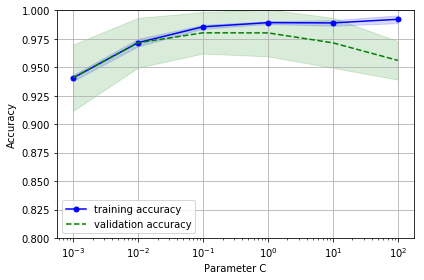

In [10]:
from sklearn.model_selection import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]

# validation_curve関数によりモデルのパラメータを変化させ交差検証による正解率を算出
# clf_CはLogisticRegressionオブジェクトのパラメータ
train_scores,test_scores = validation_curve(estimator=pipe_lr,
                                           X=X_train,
                                           y=y_train,
                                           param_name='logisticregression__C',
                                           param_range=param_range,
                                           cv=10)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(param_range,train_mean,
        color='blue',marker='o',
        markersize=5,
        label='training accuracy')
plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,color='blue')

plt.plot(param_range,test_mean,
        color='green',linestyle='--',
        markersize=5,
        label='validation accuracy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.0])
plt.tight_layout()
plt.show()

## 6.4 グリッドサーチによる機会学習モデルのチューニング
**グリッドサーチ(grid seach)**はハイパーパラメータの値の「最適」な組み合わせを見つけ出すことができる。

### グリッドサーチを使ったハイパーパラメータのチューニング

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

param_range = [0.0001,0.001,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,
              'svc__kernel':['linear']},
             {'svc__C':param_range,
             'svc__gamma':param_range,
             'svc__kernel':['rbf']}]

# ハイパーパラメータ値のリストparam_gridを指定し、
# グリッドサーチを行うGridseachCVクラスをインスタンス化
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train,y_train)

# モデルの最良スコアを出力
print(gs.best_score_)

# 最良スコアとなるパラメータ値を出力
print(gs.best_params_)

print(gs.best_estimator_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])


トレーニングデータセットから独立したテストデータセットを使って、選択されたモデルの性能を評価する。モデルを取得するにはGridseachCVオブジェクトのbest_estimator_属性を使用する。

In [12]:
clf = gs.best_estimator_
clf.fit(X_test,y_test)
print('Test accuracy: %.3f' % clf.score(X_test,y_test))

Test accuracy: 0.991


## 6.4 入れ子式の交差検証によるアルゴリズムの選択
機会学習アルゴリズムの中から最適な選択をしたい場合は、入れ子式の交差検証(nested cross-validation)も推奨される。

In [13]:
from sklearn.tree import DecisionTreeClassifier
#ハイパーパラメータ値として決定木の深さパラメータを指定し、
#グリッドサーチを行うGridseachCVをインスタンス化
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=5)
print('CV accuracy: %.3f +/-%.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.934 +/-0.016


## 6.5 さまざまな性能評価指標
**適合率(precision)**、**再現率(recall)**、**F1スコア(F1-score)**などの性能指標により、モデルの妥当性を評価できる。

### 混同行列を解釈する
混同行列は学習アルゴリズムの性能を明らかにする行列である、分類器**真陽性(true positive)**、真陰性(true negative)、偽陽性(false positive)、偽陰性(false negative)**の4つの予測の個数を報告する単なる正方行列である。

In [14]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)

# テストと予測のデータから混同行列を作成
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


誤分類に関する情報を対応づけるにはmatplotlibのmatshow関数を使用する

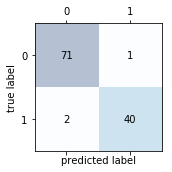

In [20]:
# 図のサイズを指定
fig,ax = plt.subplots(figsize=(2.5,2.5))
# matshow関数で行列からヒートマップを描画
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
                  ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

## 分類モデルの適合率と再現率を最適化する

In [22]:
# 適合率、再現率、F1スコアを出力
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,f1_score
print('Precision : %.3f' % precision_score(y_true=y_test,y_pred=y_pred))
print('Recall : %.3f' % recall_score(y_true=y_test,y_pred=y_pred))
print('F1 : %.3f' % f1_score(y_true=y_test,y_pred=y_pred))

Precision : 0.976
Recall : 0.952
F1 : 0.964
